In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL External Data-set")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/09/07 23:06:30 WARN Utils: Your hostname, DESKTOP-1ML24G5 resolves to a loopback address: 127.0.1.1; using 172.26.82.170 instead (on interface eth0)
22/09/07 23:06:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/07 23:06:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/07 23:06:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [62]:
income = spark.read.parquet("../../../data/tables/income_by_sa2.parquet/")

In [49]:
income.show(1, truncate = False, vertical = True)

-RECORD 0----------------------------
 SA2                     | 101021007 
 SA2_NAME                | Braidwood 
 persons_earners_2014-15 | 2133      
 persons_earners_2015-16 | 2153      
 persons_earners_2016-17 | 2262      
 persons_earners_2017-18 | 2315      
 persons_earners_2018-19 | 2361      
 med_age_earners_2014-15 | 50        
 med_age_earners_2015-16 | 50        
 med_age_earners_2016-17 | 50        
 med_age_earners_2017-18 | 51        
 med_age_earners_2018-19 | 51        
 sum_earnings_2014-15    | 101830606 
 sum_earnings_2015-16    | 109961530 
 sum_earnings_2016-17    | 115564780 
 sum_earnings_2017-18    | 119439615 
 sum_earnings_2018-19    | 120763285 
 median_earnings_2014-15 | 38093     
 median_earnings_2015-16 | 39716     
 median_earnings_2016-17 | 41288     
 median_earnings_2017-18 | 42003     
 median_earnings_2018-19 | 41593     
 mean_earnings_2014-15   | 47741     
 mean_earnings_2015-16   | 51074     
 mean_earnings_2016-17   | 51090     
 mean_earnin

In [63]:
# Select subset important attributes, ignore the rest:
cols_to_keep = ['SA2', 'SA2_NAME', 'median_earnings_2018-19', 'mean_earnings_2018-19']
income = income.select(*cols_to_keep)
income.limit(3)

SA2,SA2_NAME,median_earnings_2018-19,mean_earnings_2018-19
101021007,Braidwood,41593,51149
101021008,Karabar,61777,66335
101021009,Queanbeyan,60119,65874


In [51]:
income.printSchema()

root
 |-- SA2: string (nullable = true)
 |-- SA2_NAME: string (nullable = true)
 |-- median_earnings_2018-19: string (nullable = true)
 |-- mean_earnings_2018-19: string (nullable = true)



In [64]:
from pyspark.sql.types import IntegerType

income = income \
        .withColumn('median_earnings_2018-19', F.col('median_earnings_2018-19').cast(IntegerType())) \
        .withColumn('mean_earnings_2018-19', F.col('mean_earnings_2018-19').cast(IntegerType()))

income.printSchema()

root
 |-- SA2: string (nullable = true)
 |-- SA2_NAME: string (nullable = true)
 |-- median_earnings_2018-19: integer (nullable = true)
 |-- mean_earnings_2018-19: integer (nullable = true)



In [53]:
income.limit(3)

SA2,SA2_NAME,median_earnings_2018-19,mean_earnings_2018-19
101021007,Braidwood,41593,51149
101021008,Karabar,61777,66335
101021009,Queanbeyan,60119,65874


 # Column analysis: <br>
 1) SA2 should ONLY be 9 numbers long. <br>
 2) Median earnings for 2018-2019 should be greater than 0. <br>
 3) Mean earnings for 2018-2019 should be greater than 0. <br>
 4) Check for any NULL values in the columns. <br>
 5) Check for missing values. <br>

In [65]:
initial = income.count()

In [66]:
#1
filter1 = income.filter(F.length(F.col('SA2')) == 9)
f1 = filter1.count()
#2
filter2 = filter1.filter(F.col('median_earnings_2018-19') > 0)
f2 = filter2.count()
#3
filter3 = filter2.filter(F.col('mean_earnings_2018-19') > 0)
f3 = filter3.count()

In [83]:
#4
filter4 = filter3.filter(F.col('SA2').isNotNull())
f4 = filter4.count()
filter5 = filter4.filter(F.col('median_earnings_2018-19').isNotNull())
f5 = filter5.count()
filter6 = filter5.filter(F.col('mean_earnings_2018-19').isNotNull())
f6 = filter6.count()

income = filter6

In [84]:
print("Number of intial entries:", initial)
print("Number of entries after applying filter 1:", f1)
print("Number of entries after applying filter 2:", f2)
print("Number of entries after applying filter 3:", f3)
print("Number of entries after applying filter 4:", f4)
print("Number of entries after applying filter 5:", f5)
print("Number of entries after applying filter 6:", f6)
print("Number of entries removed:", initial-f6)

Number of intial entries: 2288
Number of entries after applying filter 1: 2288
Number of entries after applying filter 2: 2244
Number of entries after applying filter 3: 2243
Number of entries after applying filter 4: 2243
Number of entries after applying filter 5: 2243
Number of entries after applying filter 6: 2243
Number of entries removed: 45


In [85]:
# 5
print(income.filter(F.col('SA2') == "").count())
print(income.filter(F.col('median_earnings_2018-19') == "").count())
print(income.filter(F.col('mean_earnings_2018-19') == "").count())

0
0
0


# OUTLIERS

## Median income ##

In [92]:
stat1 = income.describe('median_earnings_2018-19')
stat1

summary,median_earnings_2018-19
count,2243
mean,52082.994650022294
stddev,10521.823660544445
min,10433
max,171110


In [96]:
print(income.filter(F.col('median_earnings_2018-19') > (52082.994650022294 + 3 * 10521.823660544445)).count())

18


18 entries are outliers from the median earnings column. These can be removed, but first let's see the distribution of the median income before removing them:

[Text(0.5, 1.0, 'Median Earnings($) 2018-19 (BEFORE OUTLIER REMOVAL)')]

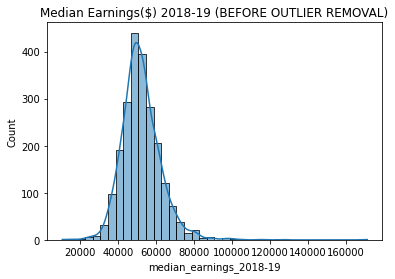

In [124]:
# Distribution of median earnings in all SA2 Districts BEFORE outlier removal.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

before_outlier_median = income.toPandas()
sns.histplot(before_outlier_median['median_earnings_2018-19'], kde=True, bins=40).set(title='Median Earnings($) 2018-19 (BEFORE OUTLIER REMOVAL)')

Let's remove the 18 outliers and see the impact it has on the median income distribution:

[Text(0.5, 1.0, 'Median Earnings($) 2018-19 (AFTER OUTLIER REMOVAL)')]

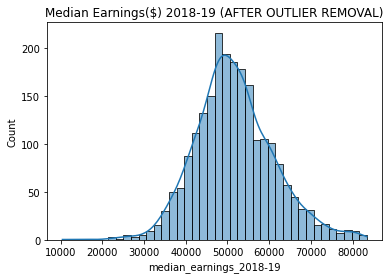

In [125]:
# Distribution of median earnings in all SA2 Districts AFTER outlier removal.

income_median_outlier_removal = income.filter(F.col('median_earnings_2018-19') <= (52082.994650022294 + 3 * 10521.823660544445))

after_outlier_median = income_median_outlier_removal.toPandas()
sns.histplot(after_outlier_median['median_earnings_2018-19'], kde=True, bins=40).set(title='Median Earnings($) 2018-19 (AFTER OUTLIER REMOVAL)')

After the removal of the outliers, the distribution of the median income has shifted towards the right whilst still maintainig its shape. It is more symmetrically distributed and balanced, compared to the distribution before outlier removal.

## Mean Income ##

In [87]:
income.describe('mean_earnings_2018-19')

summary,mean_earnings_2018-19
count,2243
mean,64405.34016941596
stddev,18774.790884914793
min,19479
max,281099


In [111]:
print(income.filter(F.col('mean_earnings_2018-19') > (64405.34016941596 + 3 * 64405.34016941596)).count())

2


2 entries are outliers from the mean earnings column. These can be removed, but first let's see the distribution of the mean income before removing them:

[Text(0.5, 1.0, 'Mean Earnings($) 2018-19 (BEFORE OUTLIER REMOVAL)')]

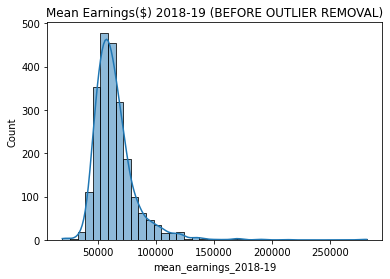

In [126]:
# Distribution of average earnings in all SA2 Districts BEFORE outlier removal.

before_outlier = income.toPandas()
sns.histplot(before_outlier['mean_earnings_2018-19'], kde=True, bins=40).set(title='Mean Earnings($) 2018-19 (BEFORE OUTLIER REMOVAL)')

Let's remove the 2 outliers and see the impact it has on the mean income distribution:

[Text(0.5, 1.0, 'Mean Earnings($) 2018-19 (AFTER OUTLIER REMOVAL)')]

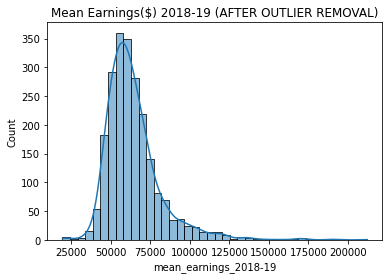

In [127]:
# Distribution of average earnings in all SA2 Districts AFTER outlier removal.

income_mean_outlier_removal = income.filter(F.col('mean_earnings_2018-19') <= (64405.34016941596 + 3 * 64405.34016941596))

after_outlier_mean = income_mean_outlier_removal.toPandas()
sns.histplot(after_outlier_mean['mean_earnings_2018-19'], kde=True, bins=40).set(title='Mean Earnings($) 2018-19 (AFTER OUTLIER REMOVAL)')

After the removal of the outliers, the distribution of the mean income is essentially identical as only two outliers were removed. It still maintains it shape and is positivley skewed.